In [1]:
import gymnasium as gym
import numpy as np
import os

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import A2C, PPO, TD3

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env





## For making GIFs

In [3]:
import gymnasium as gym
import numpy as np
import imageio

#
folder = "gifs/"

# Make the environment and the initial observation 
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]
observation = env.reset()

# Book-keeping.
num_episodes = 1 # how many gifs to make
ep_return = 0
ep_length = 0
ep_done = 0
ep_observations = []

# For video / GIF.
dur = 0.0001
#width = 250
#height = 200
env = make_vec_env(env_name, n_envs=1)
observation = env.reset()


loadedModel = PPO('MlpPolicy', env, verbose=1)
loadedModel = loadedModel.load("tmp/best_model.zip")



while ep_done < num_episodes:

    rgb_observation = env.get_images()
    #print(rgb_observation)

    #assert obs.shape == (height, width, 3), obs.shape  # height first!
    ep_observations.append(rgb_observation)

    # Take action, step into environment, etc.
    action = loadedModel.predict(observation, deterministic=True)

    (observation, reward, done, _) = env.step(action[0])

    ep_return += reward
    ep_length += 1

    if done:
        # Form GIF. imageio should read from numpy: https://imageio.github.io/
        print(f'Episode {ep_done}, cum. return: {ep_return}, length: {ep_length}.')
        ep_name = folder + f'ep_{env_name}_{str(ep_done).zfill(2)}_dur_{dur}_len_{str(ep_length).zfill(3)}.gif'
        with imageio.get_writer(ep_name, mode='I', duration=dur) as writer:
            for obs_np in ep_observations:
                writer.append_data(obs_np)

        # Reset information.
        observation = env.reset()
        ep_ret = 0
        ep_len = 0
        ep_done += 1
        ep_obs = []

Using cpu device
Episode 0, cum. return: [299.63593], length: 1119.


In [16]:
test_env = make_vec_env(env_name, n_envs=1)

evaluate_policy(model=loadedModel, env=test_env, n_eval_episodes=10)

(299.6771192, 1.203590787942461)

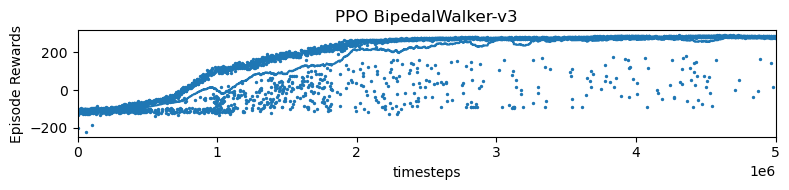

In [6]:
from stable_baselines3.common import results_plotter

log_dir = "tmp/"
plot_title = "PPO BipedalWalker-v3" 
timesteps = 5e6

# Helper from the library
results_plotter.plot_results(
    [log_dir], None, results_plotter.X_TIMESTEPS, plot_title
)

In [ ]:
import gymnasium as gym
import numpy as np
import os

from stable_baselines3 import A2C, PPO, TD3 # these are the algorithms (models) we can use
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

from Callbacks import SaveOnBestTrainingRewardCallback

# directory to save the log files in




###   TRAINING UTILS  ###
# Logs will be saved in log_dir/monitor.csv
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

callback = SaveOnBestTrainingRewardCallback(check_freq=500, log_dir=log_dir)




### ENVIRONMENT ###
# Create and wrap the environment
env_name = "BipedalWalker-v3"

#env = gym.make(env_name)
#env = Monitor(env, log_dir)
#n_actions = env.action_space.shape[-1]

vec_env = make_vec_env(env_name, n_envs=16)
vec_env = VecMonitor(vec_env, log_dir)

### MAKE THE MODEL  ###
model = PPO('MlpPolicy', vec_env, verbose=0,
            n_steps = 2048,
            batch_size = 64,
            gae_lambda= 0.95,
            gamma= 0.999,
            n_epochs= 10,
            ent_coef= 0.0,
            learning_rate= 3e-4,
            clip_range= 0.18,
        )


/home/daniel/miniconda3/envs/DRLenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [ ]:
### TRAIN
timesteps = 5e6

model.learn(total_timesteps=int(timesteps), callback=callback)

Num timesteps: 8000
Best mean reward: -inf - Last mean reward per episode: -106.15
Saving new best model to tmp/best_model.zip
Num timesteps: 16000
Best mean reward: -106.15 - Last mean reward per episode: -108.77
Num timesteps: 24000
Best mean reward: -106.15 - Last mean reward per episode: -108.77
Num timesteps: 32000
Best mean reward: -106.15 - Last mean reward per episode: -110.08


KeyboardInterrupt: 

In [ ]:
from stable_baselines3.common import results_plotter

plot_title = "PPO " + env_name

# Helper from the library
results_plotter.plot_results(
    [log_dir], timesteps, results_plotter.X_TIMESTEPS, plot_title
    )